# Anomaly Detection and Recommender Systems

Copyright 2018 Wes Barnett

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
%matplotlib inline

## 1 Anomaly detection

In [2]:
df = sio.loadmat('ex8data1.mat')
X = df['X']
X_val = df['Xval']
y_val = df['yval'].ravel()

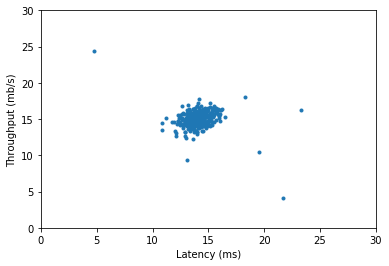

In [3]:
plt.plot(X[:,0], X[:,1], lw=0, marker='.')
plt.xlim([0,30])
plt.ylim([0,30])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

In [4]:
def estimateGaussian(X):
    return np.mean(X, axis=0), np.var(X, axis=0)

In [5]:
mu, sigma2 = estimateGaussian(X)

In [6]:
from scipy.stats import multivariate_normal

In [7]:
X.shape

(307, 2)

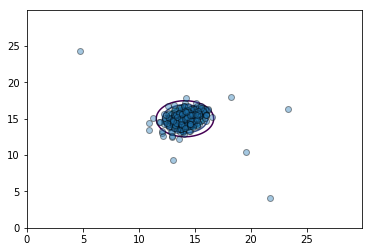

In [8]:
x, y = np.mgrid[0:30:.1, 0:30:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mu, sigma2)
plt.contour(x, y, rv.pdf(pos))
plt.plot(X[:,0], X[:,1], lw=0, marker='o', alpha=0.4, markeredgecolor='black')
plt.show()

In [9]:
p_val = rv.pdf(X_val)

In [10]:
def selectThreshold(y_val, p_val):
    bestF1 = 0.;
    stepsize = (np.max(p_val) - np.min(y_val)) / 1000.0
    for epsilon in np.arange(np.min(p_val), np.max(p_val), stepsize):
        predictions = p_val < epsilon
        tp = np.sum((y_val == 1) & (predictions == 1))
        fp = np.sum((y_val == 1) & (predictions == 0))
        fn = np.sum((y_val == 0) & (predictions == 1))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = 2.0 * precision * recall / (precision + recall)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
        
            
    return bestEpsilon, bestF1

In [11]:
eps, F1 = selectThreshold(y_val, p_val)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [12]:
# expect eps = 8.99e-5, F1 = 0.875
eps, F1

(8.990852779269493e-05, 0.8750000000000001)

In [13]:
outliers = np.argwhere(p_val < eps).ravel()

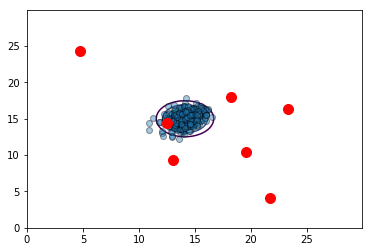

In [14]:
plt.contour(x, y, rv.pdf(pos))
plt.plot(X[:,0], X[:,1], lw=0, marker='o', alpha=0.4, markeredgecolor='black')
plt.plot(X[outliers,0], X[outliers,1], marker='o', lw=0, ms=10, color='red')

In [15]:
df = sio.loadmat('ex8data2.mat')
X = df['X']
X_val = df['Xval']
y_val = df['yval'].ravel()

In [16]:
mu, sigma2 = estimateGaussian(X)

In [17]:
p_val = multivariate_normal(mu, sigma2).pdf(X_val)

In [18]:
eps, F1 = selectThreshold(y_val, p_val)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [19]:
eps, F1

(1.377228890820894e-18, 0.6153846153846154)

In [20]:
print('Outliers: {0}'.format(np.sum(p_val < eps).ravel()))

Outliers: [16]


## 2 Recommender systems



In [21]:
df = sio.loadmat('ex8_movies.mat')
Y = df['Y']
R = df['R']

In [22]:
Y.shape

(1682, 943)

In [23]:
with open('movie_ids.txt') as f:
    movieList = [line.strip('\n') for line in f.readlines() ]

In [24]:
len(movieList)

1682

In [25]:
# We're not using the R matrix - instead if a user hasn't rated a movie we will just have 'NaN' for that entry
Y = pd.DataFrame(Y)
Y = Y[pd.DataFrame(R) == 1]
Y['movie'] = movieList
Y.set_index('movie', inplace=True)

In [26]:
Y.shape

(1682, 943)

In [27]:
Y.head()

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
movie,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
GoldenEye (1995),3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
Four Rooms (1995),4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Get Shorty (1995),3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
Copycat (1995),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Average rating for Toy Story

In [28]:
Y.loc['Toy Story (1995)'].mean()

3.8783185840707963

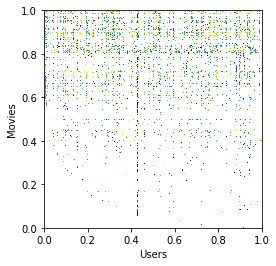

In [29]:
plt.imshow(Y, extent=[0, 1, 0, 1])
plt.ylabel('Movies')
plt.xlabel('Users')
plt.show()

In [30]:
df = sio.loadmat('ex8_movieParams.mat')
X = df['X']
Theta = df['Theta']
num_users = df['num_users']
num_movies = df['num_movies']
num_features = df['num_features']

# Data is reduced in the original course exercise
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies,:num_features]
Theta = Theta[:num_users,:num_features]
Y_tmp = Y.iloc[:num_movies,:num_users]
params = np.concatenate((X.ravel(), Theta.ravel()))

In [31]:
Y_tmp

,0,1,2,3
movie,,,,
Toy Story (1995),5.0,4.0,NaN,NaN
GoldenEye (1995),3.0,NaN,NaN,NaN
Four Rooms (1995),4.0,NaN,NaN,NaN
Get Shorty (1995),3.0,NaN,NaN,NaN
Copycat (1995),3.0,NaN,NaN,NaN


$J(x^{(1)},...,x^{(n_{m})},\theta^{(1)},...,\theta^{(n_{u})}) = \frac{1}{2} \sum_{(i,j);r(i,j)=1} ( (\theta^{(j)})^{T}x^{(i)}-y^{(i,j)})^{2} ) + ( \frac{\lambda}{2} \sum_{j=1}^{n_{u}}\sum_{k=1}^{n}(\theta_{k}^{(j)})^{2}  ) + ( \frac{\lambda}{2} \sum_{i=1}^{n_{m}}\sum_{k=1}^{n}(x_{k}^{(i)})^{2}  )$

In [32]:
def cofiCostFunc(params, Y, n0, n1, num_features, lamb):
    X, Theta = np.split(params, [n0*num_features])
    X = X.reshape(n0, -1)
    Theta = Theta.reshape(n1, -1)
    J = 0.5 * ((((np.matmul(Theta,X.T)).T - Y)**2).fillna(0).values.sum() + lamb*np.sum(Theta**2) + lamb*np.sum(X**2))
    return J

In [33]:
# Expect about 22.22
cofiCostFunc(params, Y_tmp, num_movies, num_users, num_features, 0)

22.22460372568567

$\frac{\delta J}{\delta x_{k}^{(i)}} = \sum_{j:r(i,j)=1} ((\theta^{(j)})^{T}x^{(i)}-y^{(i,j)})\theta_{k}^{(j)} + \lambda x_{k}^{(i)}$

$\frac{\delta J}{\delta \theta_{k}^{(j)}} = \sum_{i:r(i,j)=1} ((\theta^{(j)})^{T}x^{(i)}-y^{(i,j)})\theta_{k}^{(i)} + \lambda \theta_{k}^{(j)}$

In [34]:
# Fully vectorized implementation
def cofiGradFunc(params, Y, n0, n1, num_features, lamb):
    X, Theta = np.split(params, [n0*num_features])
    X = X.reshape(n0, -1)
    Theta = Theta.reshape(n1, -1)
    X_grad = (np.matmul(Theta.T, (np.matmul(Theta, X.T) - Y.T).fillna(0)) + lamb*X.T).T
    Theta_grad = (np.matmul(X.T, (np.matmul(Theta, X.T) - Y.T).fillna(0).T) + lamb*Theta.T).T
    return np.concatenate([X_grad.ravel(), Theta_grad.ravel()])

In [35]:
cofiGradFunc(params, Y_tmp, num_movies, num_users, num_features, 0)

array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
         3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
        -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
        -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
         4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
        -3.47410789,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ])

In [36]:
# Expect about 31.34
cofiCostFunc(params, Y_tmp, num_movies, num_users, num_features, 1.5)

31.344056244274213

In [37]:
new_user = pd.Series({'Toy Story (1995)': 4.,
           'Silence of the Lambs, The (1991)': 2.,
           'Twelve Monkeys (1995)': 3.,
           'Usual Suspects, The (1995)': 5.,
           'Outbreak (1995)': 4.,
           'Shawshank Redemption, The (1994)': 5.,
           'While You Were Sleeping (1995)': 3.,
           'Forrest Gump (1994)': 5.,
           'Alien (1979)': 4.,
           'Die Hard 2 (1990)': 5.,
           'Sphere': 5.})

In [38]:
new_user

Toy Story (1995)                    4.0
Silence of the Lambs, The (1991)    2.0
Twelve Monkeys (1995)               3.0
Usual Suspects, The (1995)          5.0
Outbreak (1995)                     4.0
Shawshank Redemption, The (1994)    5.0
While You Were Sleeping (1995)      3.0
Forrest Gump (1994)                 5.0
Alien (1979)                        4.0
Die Hard 2 (1990)                   5.0
Sphere                              5.0
dtype: float64

In [39]:
Y['me'] = new_user

In [40]:
from scipy.optimize import minimize

def run_collaborative_filtering(Y, num_features, l):
    
    # n0 = rows (movies)
    # n1 = cols (users)
    n0 = Y.shape[0]
    n1 = Y.shape[1]
    
    # Random initilization of parameters, stacked into one flat array
    Theta = np.random.randn(n0, num_features)
    X = np.random.randn(n1, num_features)
    x0 = np.hstack([X.ravel(), Theta.ravel()])
    
    # Subtract the mean for each movie
    Ynorm = Y.sub(Y.mean(axis=1), axis=0)
    
    minimize_result = minimize(cofiCostFunc, x0, method="L-BFGS-B", 
                           jac=cofiGradFunc, args=(Ynorm, n0, n1, num_features, l), 
                           options={"maxiter": 1000})
    
    X, Theta = np.split(minimize_result.x, [n0*num_features])
    X = X.reshape(n0, -1)
    Theta = Theta.reshape(n1, -1)
    
    # Create a DataFrame of the predictions; we have to add back the mean
    p = pd.DataFrame(np.matmul(X, Theta.T), index=Y.index, columns=Y.columns)
    p = p.add(Y.mean(axis=1), axis=0)
    return p

In [41]:
p = run_collaborative_filtering(Y, 10, 10.)

Predictions based on "my" ratings.

In [42]:
p['me'].sort_values(ascending=False)

movie
Entertaining Angels: The Dorothy Day Story (1996)         5.000002
Prefontaine (1997)                                        5.000002
Santa with Muscles (1996)                                 5.000001
Saint of Fort Washington, The (1993)                      5.000001
Marlene Dietrich: Shadow and Light (1996)                 5.000000
Someone Else's America (1995)                             5.000000
Great Day in Harlem, A (1994)                             5.000000
Star Kid (1997)                                           5.000000
Aiqing wansui (1994)                                      4.999999
They Made Me a Criminal (1939)                            4.999999
Pather Panchali (1955)                                    4.630567
Star Wars (1977)                                          4.588330
Shawshank Redemption, The (1994)                          4.540853
Maya Lin: A Strong Clear Vision (1994)                    4.504387
Anna (1996)                                             